In [11]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tkinter import *
from pycochleagram import cochleagram as cgram
from pycochleagram import erbfilter as erb
from pycochleagram import utils
print("Matplotlib plt backend: {}".format(plt.get_backend()))

Matplotlib plt backend: module://matplotlib_inline.backend_inline


In [7]:
demo_stim, demo_sr = librosa.load('../../../DCASE2017-baseline-system/applications/data/TUT-sound-events-2017-development/audio/street/a001.wav')
demo_n = 38  # default filter for low_lim=50 hi_lim=20000
# demo_stim=demo_stim/max(demo_stim)

In [15]:
D = np.abs(librosa.stft(demo_stim))**2
S = librosa.feature.melspectrogram(y=demo_stim, sr=demo_sr,  n_mels=128,
                                    fmax=8000)

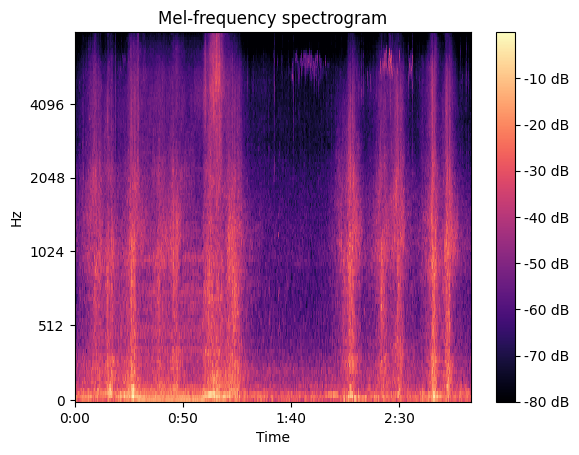

In [16]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=demo_sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
plt.show()

In [3]:
def demo_human_cochleagram_helper(signal, sr, n, sample_factor=2, downsample=None, nonlinearity=None):
  human_coch = cgram.human_cochleagram(signal, sr, n=n, sample_factor=sample_factor,
      downsample=downsample, nonlinearity=nonlinearity, strict=False)
  img = (human_coch)  # the cochleagram is upside down (i.e., in image coordinates)
  return img



In [4]:
def demo_human_cochleagram(signal=None, sr=None, n=None):
  coch_pow = demo_human_cochleagram_helper(signal, sr, n, nonlinearity='power', downsample=10000)
  print(coch_pow.shape)
  return coch_pow


In [5]:
# oenv = librosa.onset.onset_strength(y=demo_stim, sr=demo_sr, hop_length=512) 
coch_arr = demo_human_cochleagram(demo_stim, demo_sr, demo_n)

here


c:\Python310\lib\site-packages\pycochleagram-0.1-py3.10.egg\pycochleagram\cochleagram.py:129: RuntimeWarning: input arg "hi_lim" exceeds nyquist limit for max frequency; ignore with "strict=False"
  filts, hz_cutoffs, freqs = erb.make_erb_cos_filters_nx(batch_signal.shape[1],
c:\Python310\lib\site-packages\pycochleagram-0.1-py3.10.egg\pycochleagram\cochleagram.py:135: RuntimeWarning: divide by zero encountered in log10
  freqs_to_plot = np.log10(freqs)


(81, 300001)


In [6]:
shaped_arr = np.zeros((81,1292))
for x in range(0 ,coch_arr.shape[0]):
    new_arr = np.array([])
    for i in range(0,1292):
        if(i*232<coch_arr.shape[1]):
            mean=0
            if(i>0):
                sub_arr = coch_arr[x:x+1, (i-1)*232: i*232]
                mean = np.mean(sub_arr)
            else:
                mean = coch_arr[x][0]
            new_arr = np.append(new_arr, [mean])
        else:
            break
    shaped_arr[x] = new_arr
print(shaped_arr.shape)

(81, 1292)


In [7]:
shaped_arr = np.repeat(shaped_arr,5,axis=0)
shaped_arr = shaped_arr[:384, :]
print(shaped_arr.shape)

(384, 1292)


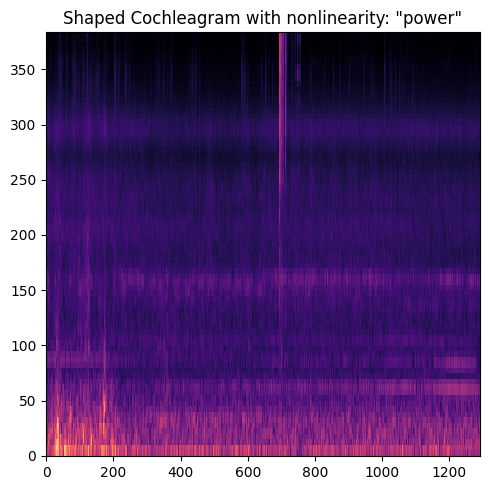

In [15]:
plt.subplots(figsize=(5,5))
plt.title('Shaped Cochleagram with nonlinearity: "power"')
plt.imshow(abs((shaped_arr)), aspect='auto', cmap='magma', interpolation='nearest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [9]:
hop_length = 512
oenv = librosa.onset.onset_strength(y=demo_stim, sr=demo_sr, hop_length=hop_length)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=demo_sr,
                                      hop_length=hop_length)
print(tempogram.shape)
print(oenv.shape)
tempo = librosa.beat.tempo(onset_envelope=oenv, sr=demo_sr,
                           hop_length=hop_length)[0]

(384, 1292)
(1292,)


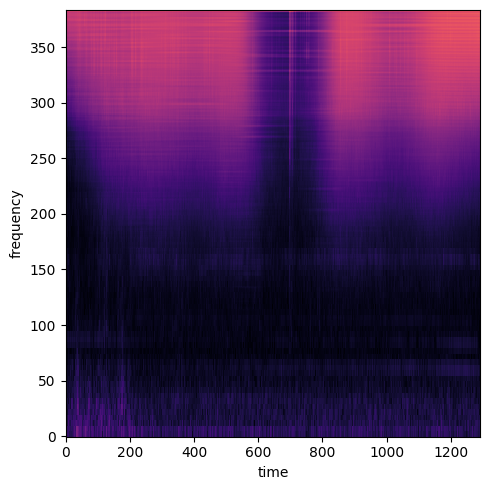

In [16]:
final_arr = np.add(np.flipud(tempogram),shaped_arr)
plt.subplots(figsize=(5,5))
plt.ylabel('frequency')
plt.xlabel('time')
plt.imshow((final_arr), aspect='auto', cmap='magma', interpolation='nearest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

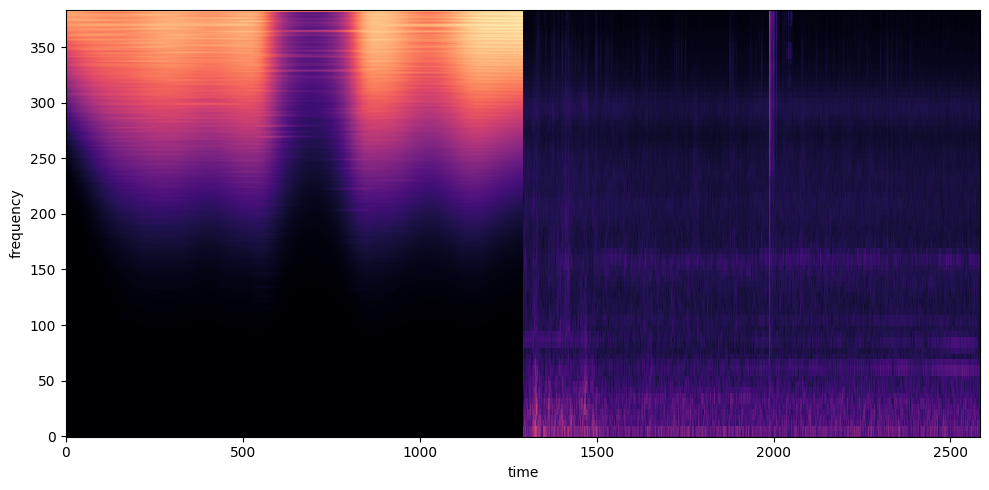

In [18]:
final_arr2 = np.hstack((np.flipud(tempogram), shaped_arr))
plt.subplots(figsize=(10,5))
plt.ylabel('frequency')
plt.xlabel('time')
plt.imshow((final_arr2), aspect='auto', cmap='magma', interpolation='nearest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

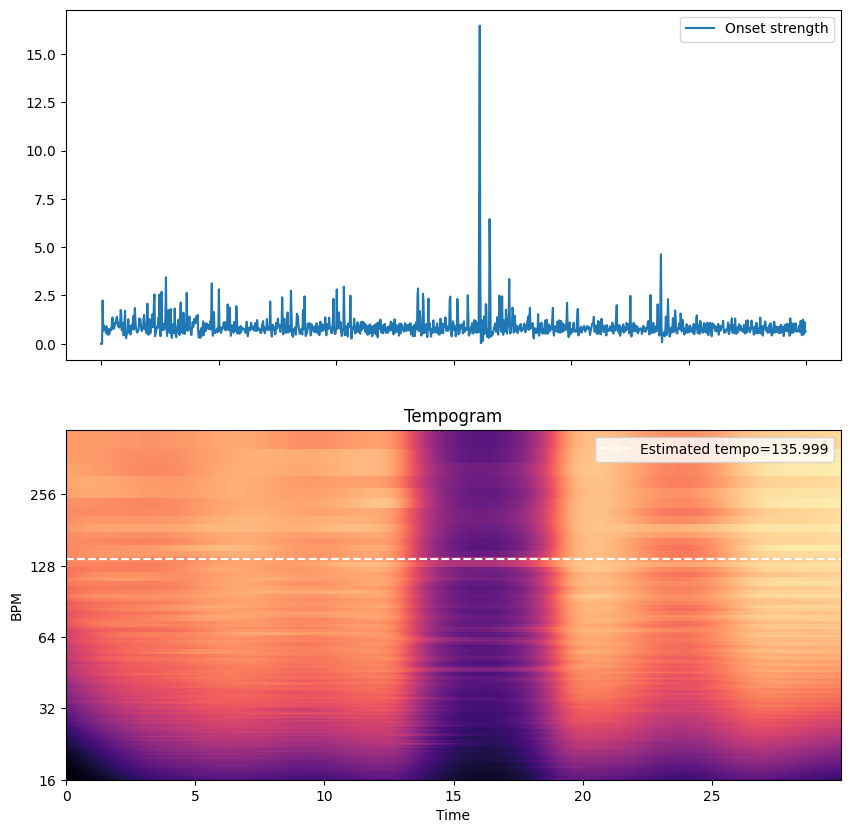

In [17]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
times = librosa.times_like(oenv, sr=demo_sr, hop_length=hop_length)
ax[0].plot(times, oenv, label='Onset strength')
ax[0].label_outer()
ax[0].legend(frameon=True)
librosa.display.specshow(tempogram, sr=demo_sr, hop_length=hop_length,
                         x_axis='time', y_axis='tempo', cmap='magma',
                         ax=ax[1])
ax[1].axhline(tempo, color='w', linestyle='--', alpha=1,
            label='Estimated tempo={:g}'.format(tempo))
ax[1].legend(loc='upper right')
ax[1].set(title='Tempogram')
plt.savefig('tempogram.jpg')
